## We will build a model of the house prices in the state of California.
The data includes metrics such as:
* Population  
* Median income
* Median housing price per block group (a geographical unit)

The goal of the model is to predict the median housing price in any district given these metrics

### Framing the problem
The output (i.e. the prediction of a district's median housing price) will be fed to another ML system, which in turn will determine if it's worth investing in the area. 

Currently, the prices are estimated manually by experts. In addition to the costs the manual estimates are often upwards of 30% off.

#### Solution outline
The task is a supervised learning task, as there are labeled examples that can train the output. 
As we are asked to predict a _single_ value based on several parameters it is a univariate multiple regression problem. 

Finally, the data is fixed and a relatively small volume so it can be done in memory and without consideration of new data. 

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import requests

def download_housing_data():
    '''
    Download dataset from Aurelien Gerons github. If the dataset exists it is not downloaded
    '''
    file_path = Path("datasets/housing.tgz")
    if not file_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as writer:
                writer.write(response.raw.read())
        with tarfile.open(file_path) as housing_tar:
            housing_tar.extractall(path="datasets")
#download_housing_data()


# Exploratory data analysis

In [2]:
# Load housing data
housing = pd.read_csv("datasets/housing/housing.csv")

In [3]:
# Read first couple of rows
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# Descriptive statistics
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

<function matplotlib.pyplot.show(close=None, block=None)>

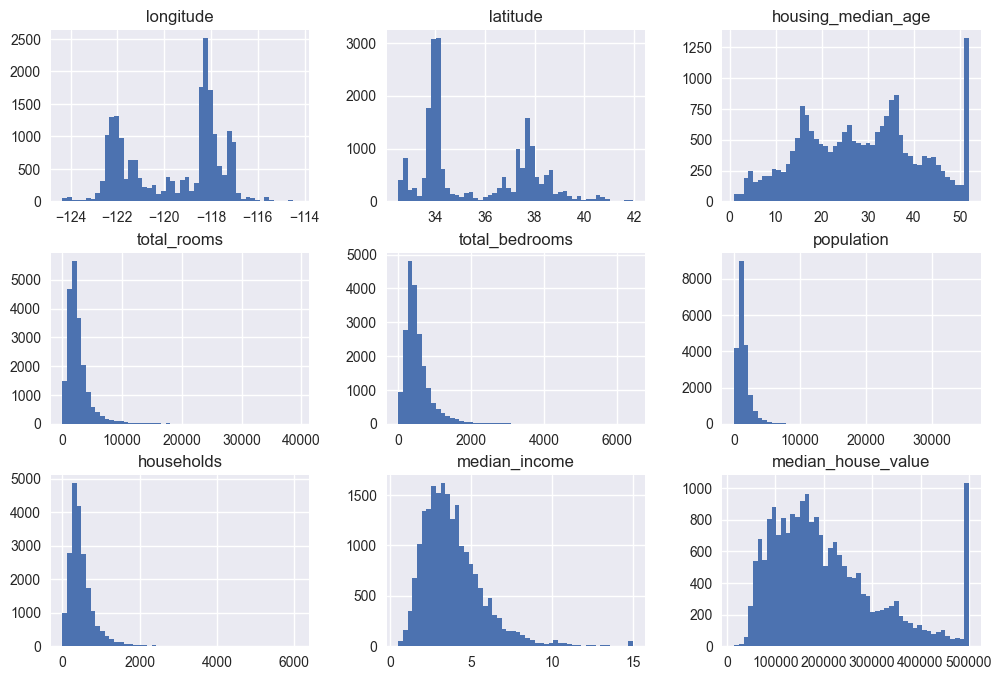

In [5]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

housing.hist(bins=50, figsize=(12,8))
plt.show

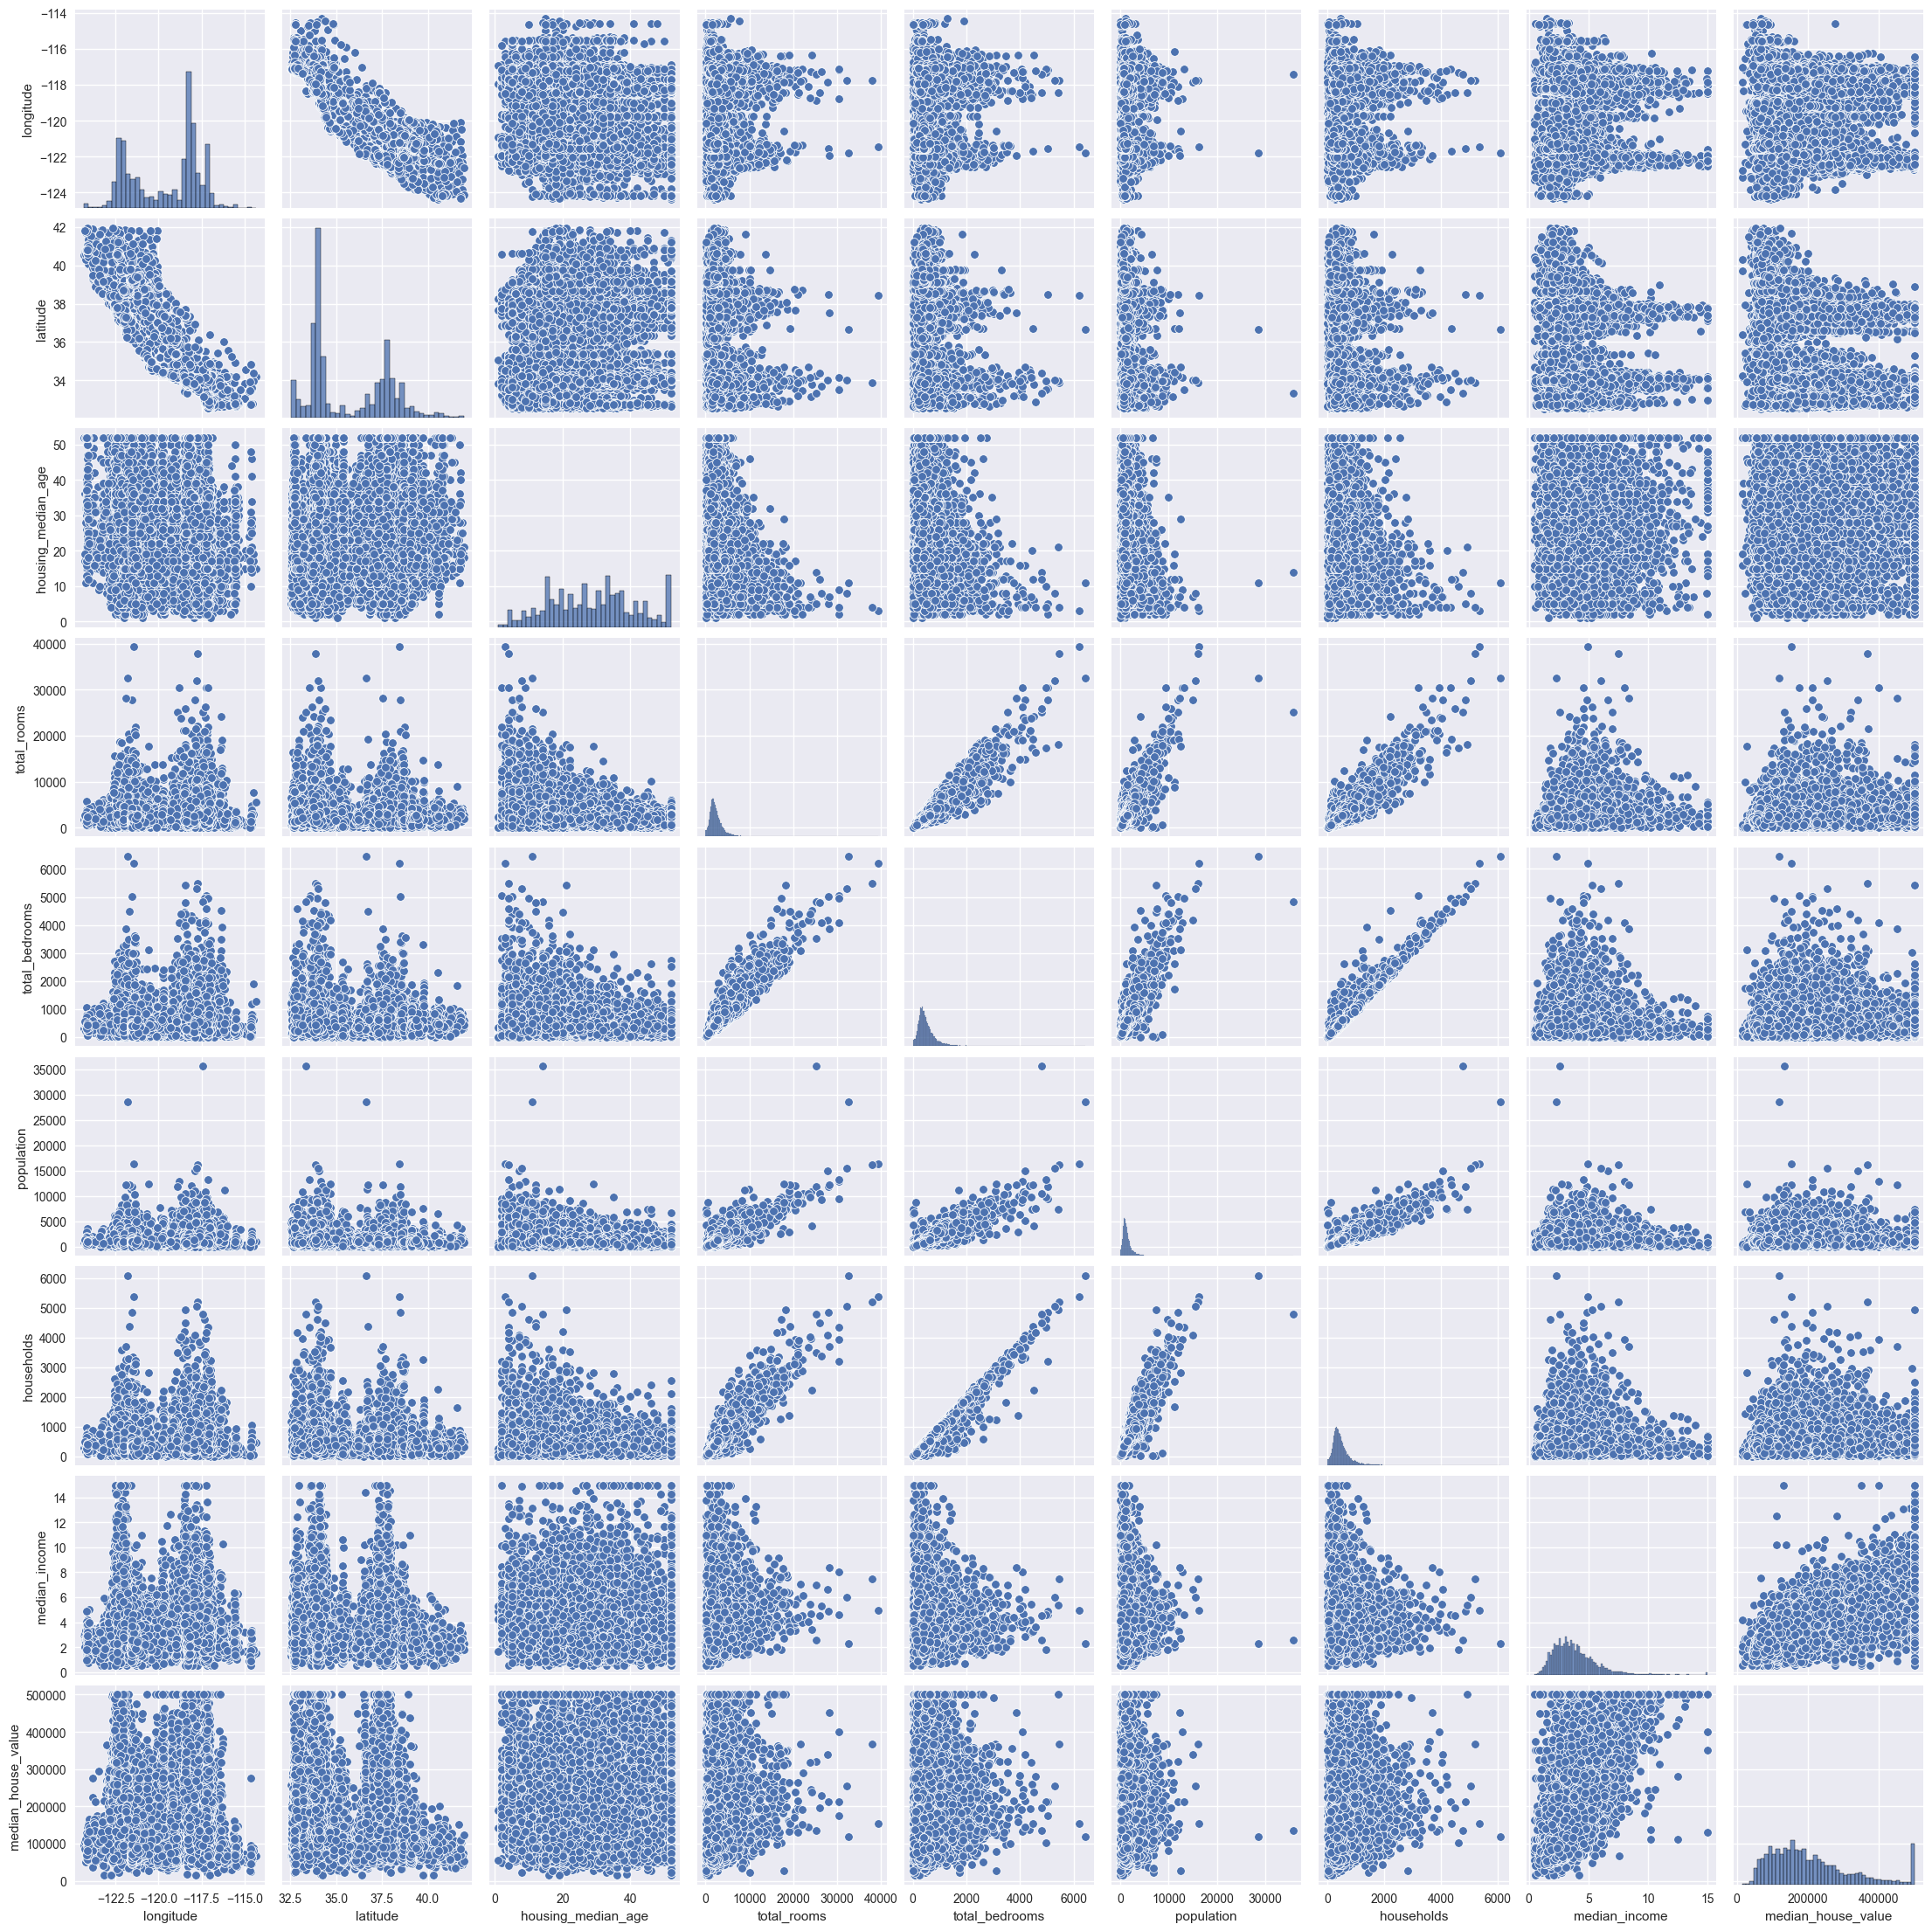

In [6]:
# Overkill
import seaborn as sns 
##sns.pairplot(housing)

* Median income is not expressed in USD, but is given in tens of thousands of dollars.  
* Housing median age and median house values are capped which could / can cause problems.
* Datasets are skewed right - this can cause some ML algorithms to fail at detecting patterns.  

### Splitting test and training data
Basically scikit learn can be used to test data but here are some manual implementations to get the hang of it:

In [7]:
# Create test set
import numpy as np

def shuffle_and_split_dat(data, test_ratio):
    '''
    This function will split data into a training dataset and a test dataset. 
    Every time the model runs (m) data will be regenerated, meaning the procedure slowly will go through the entire dataset.
    To avoid this np.random.seed(x) can be set, but this implementation will break the next time the dataset is updated.   
    '''
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

### Keeping state between runs
Keeping consistency between runs can be ensured is to use each instances identifier to decide whether or not it should go into the test set.

In [8]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    '''
    
    '''
    return crc32(np.int64(identifier) < test_ratio * 2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
    '''
    
    '''
    ids = data[id_column]
    in_test_set = ids.applit(lambda id_: is_id_in_test_set(id, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
# Usage of the above
housing_with_id = housing.reset_index() 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

AttributeError: 'Series' object has no attribute 'applit'

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state = 42) 

### Sampling methods
The previously used sampling methods have been purely random - which is fine with large datasets. If it isn't you risk introducing sampling bias. 
It is important to ensure that the training data is representative. This can be done by using stratified sampling - here the popoulation is divided into homogenous subgroups called strata.

Its important to have a sufficient number of instances in the dataset per stratum, else the estimate of the stratum's importance may be biased.

This means that each strata should be large enough and that there shouldnt be too many of them. 

<AxesSubplot:xlabel='median_income', ylabel='Count'>

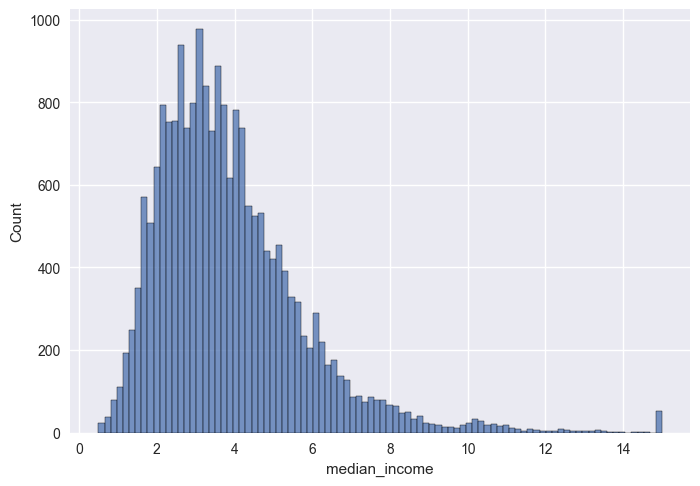

In [17]:
sns.histplot(data=housing['median_income'])

Looking at the histogram of median incomes from earlier it can be seen that most median incomes are centered around the 1.5 to 6 bracket. Some do go further though. Using the previous knowledge of strata we are going to create a new income strategy with just five categories.

<function matplotlib.pyplot.show(close=None, block=None)>

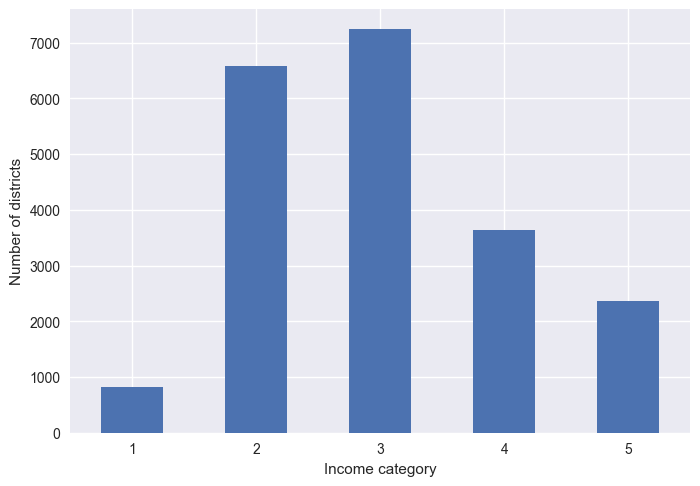

In [20]:
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show

We can now perform stratified sampling based on this new income category.
Several options are available in the sklearn.model_selection package. The methods split() return indices - not the data.

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [22]:
strat_train_set, strat_test_set = strat_splits[0]

In [23]:
# Getting a single split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [24]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [25]:
# Dropping the income categories again
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
housing = strat_train_set.copy() 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

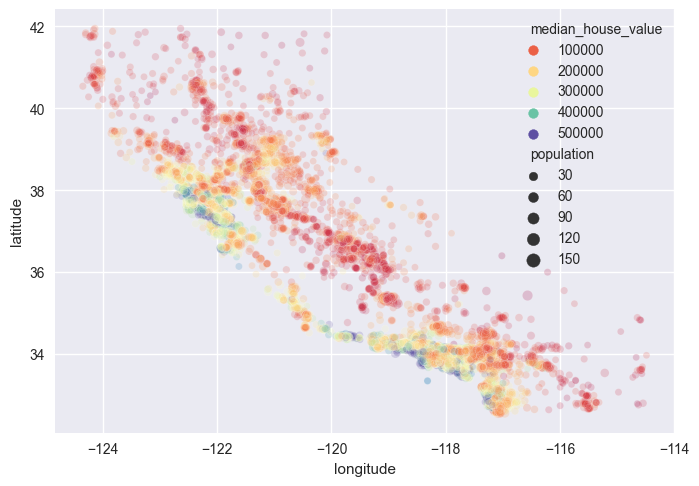

In [44]:
sns.scatterplot(housing, palette="Spectral", x="longitude",y="latitude",size=housing["population"]/100, hue="median_house_value", alpha=0.2)
#housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
#plt.show()

From this graph we can see that housing prices seem to be correlated with location and population density.

This can be checked out by calculating Pearson's R - the standard correlation coefficient - between every pair of attributes.

In [36]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Another way is by using the scatter_matrix() function in Pandas. This gives a plot per attribute giving $11^2$ plots.

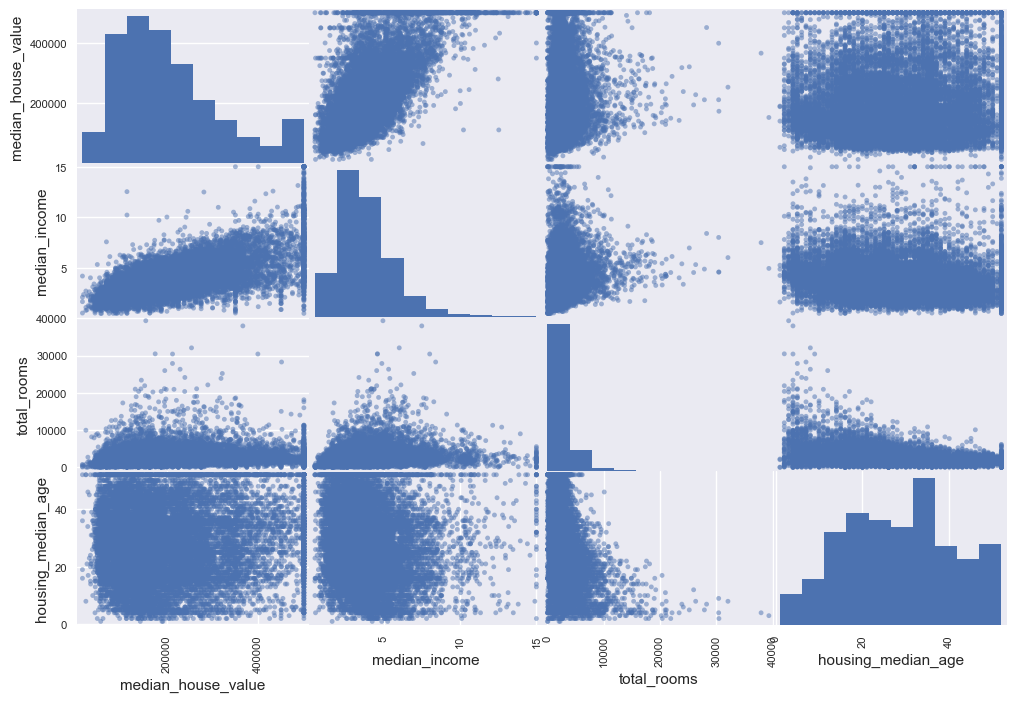

In [38]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
                "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

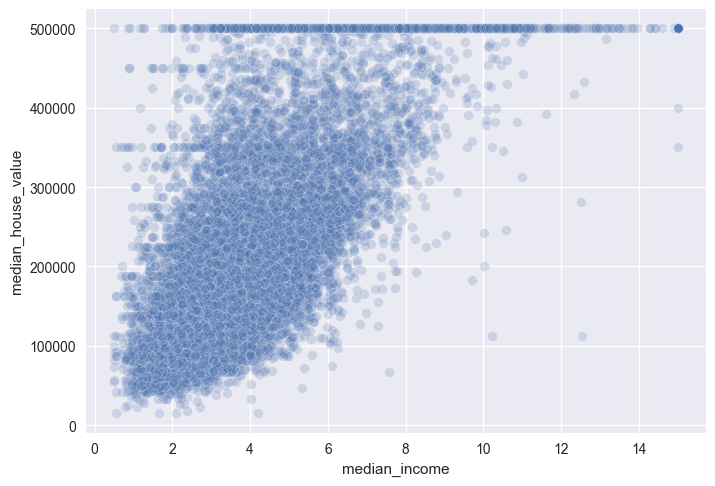

In [43]:
sns.scatterplot(housing, x="median_income", y="median_house_value", alpha=0.2)

There is a clear upward trend in the data without too much dispersion between the points. The price cap in the data is clearly visible towards the top of the plot. Additional lines are visible around 450k and 350k. 

In [45]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [46]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Machine Learning here we come 

In [ ]:
# Initialize new training dataset
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()  

### Cleaning the data
Some attributes are missing - total_bedrooms for instance has some missing values. We can:
* Get rid of the corresponding districts
* Get rid of the whole attribute
* Set the missing values to some value (mean, median, zero, ...) - also known as imputation.

In [ ]:
# Drop districts
housing.dropna(subset=["total_bedrooms"], inplace=True)

# Drop attribute
housing.drop("total_bedrooms",axis=1)

# Replace missing values
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

In [47]:
# Use sci-kits imputer to ease the task now and later
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # mean, most_frequent or constant can also be used

housing_num = housing.select_dtypes(include=[np.number])

In [52]:
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.12500000e+03,
        4.34000000e+02,  1.16700000e+03,  4.08000000e+02,  3.53850000e+00,
        1.79200000e+05,  5.23557310e+00,  2.03105786e-01,  2.82231619e+00])

This imputer which has been "trained" can now be used to transform the training set by replacing with learned medians: 

In [53]:
X = imputer.transform(housing_num)

In [56]:
# As all outputs from scikit-learn output NumPy arrays we have to wrap our X
# in a DataFrame to recover the column names

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_cat = housing[['ocean_proximity']]

In [57]:
# Transforming our categorical data into numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)


In [63]:
# Creating dummy attributes in stead
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])